In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from tensorflow.keras.constraints import max_norm
from keras.utils import np_utils
import numpy as np
import random
import os
import re
import string
import glob
import sys
import io
print("GPU:", tf.test.gpu_device_name())

TensorFlow 2.x selected.
Tensorflow version: 2.0.0


Using TensorFlow backend.


GPU: /device:GPU:0


In [2]:
!git clone https://github.com/michalovsky/books_data.git

Cloning into 'books_data'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 67 (delta 16), reused 48 (delta 9), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [3]:
# Read all text file paths from directory
directory1 = "books_data/kafka/"
directory2 = "books_data/shelley/"
directory3 = "books_data/defoe/"
directory4 = "books_data/plato/"

directory = directory4
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 1 text files in directory: books_data/plato/


In [4]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
        file_content = file.read()
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1194952 characters


In [5]:
# Preprocess data

punctuation_translator = str.maketrans('–—”„…«»‘’“°ſ†•✠', '               ', string.punctuation)
digits_translator = str.maketrans('', '', string.digits)
special_characters_translator = str.maketrans('ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï', 'acelnoszzaoueeeeoaaaeceinouuuaei', '')

# remove redundant characters and translate special characters
text = text.lower().translate(punctuation_translator).translate(digits_translator).translate(special_characters_translator)

# remove "chapter <number>" strings 
text = re.sub(r"\nchapter\s(.*)\n", "", text)

#remove extra spaces and new lines
text = ' '.join(text.split())

print ('Length of text after preprocessing: {} characters'.format(len(text)))

vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print ('{} unique characters:'.format(len(vocab)))

words = text.split()
print('Total words:', len(words))
print('Unique words:', len(set(words)))

Length of text after preprocessing: 1156643 characters
27 unique characters:
Total words: 215852
Unique words: 11225


In [6]:
# organize into sequences of words: 50 input 1 output
length = 50 + 1
sequences = list()
for i in range(length, len(words)):
	seq = words[i-length:i]
	line = ' '.join(seq)
	sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 215801


In [0]:
# Encode sequences of words
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
tokens = tokenizer.texts_to_sequences(sequences)

vocab_size = len(tokenizer.word_index) + 1

In [0]:
from sklearn.model_selection import train_test_split

data = np.asarray(tokens)
X, y = data[:,:-1], data[:,-1]
y = np_utils.to_categorical(y, num_classes=vocab_size)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [16]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=X.shape[1]))
model.add(LSTM(100, return_sequences=True, recurrent_initializer='glorot_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(LSTM(100, recurrent_initializer='glorot_uniform'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 200)           2245200   
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 256)           467968    
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 256)           1024      
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)              

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)
callbacks = [ es]

batch_size = 128
epochs = 60
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks)

Train on 172640 samples, validate on 43161 samples
Epoch 1/60
172640/172640 - 67s - loss: 6.1800 - accuracy: 0.0993 - val_loss: 6.0603 - val_accuracy: 0.1164
Epoch 2/60
172640/172640 - 60s - loss: 5.6237 - accuracy: 0.1433 - val_loss: 5.6469 - val_accuracy: 0.1526
Epoch 3/60
172640/172640 - 59s - loss: 5.3304 - accuracy: 0.1658 - val_loss: 5.5540 - val_accuracy: 0.1695
Epoch 4/60
172640/172640 - 60s - loss: 5.1330 - accuracy: 0.1799 - val_loss: 5.5273 - val_accuracy: 0.1749
Epoch 5/60
172640/172640 - 60s - loss: 4.9766 - accuracy: 0.1906 - val_loss: 5.5359 - val_accuracy: 0.1789
Epoch 6/60
172640/172640 - 62s - loss: 4.8457 - accuracy: 0.1975 - val_loss: 5.5617 - val_accuracy: 0.1797
Epoch 7/60
172640/172640 - 62s - loss: 4.7208 - accuracy: 0.2056 - val_loss: 5.6249 - val_accuracy: 0.1850
Epoch 8/60
172640/172640 - 62s - loss: 4.6092 - accuracy: 0.2116 - val_loss: 5.7147 - val_accuracy: 0.1845
Epoch 9/60
172640/172640 - 62s - loss: 4.5034 - accuracy: 0.2190 - val_loss: 5.8021 - val_acc

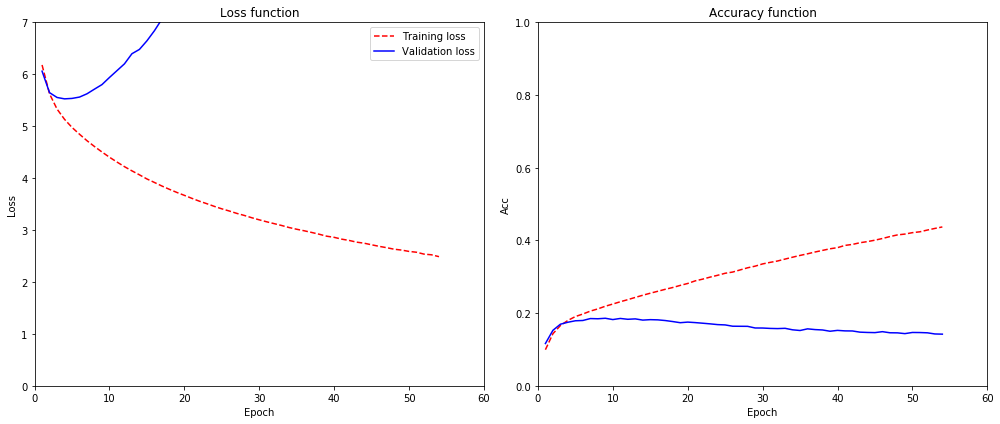

In [18]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)
# plt.savefig(save_directory+"/characteristics.png")  

plt.tight_layout()
plt.show()

In [0]:
from keras.preprocessing.sequence import pad_sequences

# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
	result = list()
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)

In [29]:
# select a seed text
from random import randint
seq_length = X.shape[1]
seed_text = sequences[randint(0,len(sequences))]
print(seed_text + '\n')
 
# generate new text
generated = generate_seq(model, tokenizer, 50, seed_text, 50)
print(generated)

he is the father if it steals into life will have been conceived under auspices very unlike the sacrifices and prayers which at each hymeneal priestesses and priest and the whole city will offer that the new generation may be better and more useful than their good and useful parents whereas

his soul is solely actuated by love of truth foodwhich he and is the reverse of the reverse of the reverse of employing i mean to be the same violation of the world all things for defeat and soothing conceivable their theology and not to be found in the same
